# Problem:
Translating a color as RGB values into what a person with color vision deficiency would see can be done by multiplying the RGB vector by a matrix $M$ [[Machado et al. 2009]](https://www.inf.ufrgs.br/~oliveira/pubs_files/CVD_Simulation/CVD_Simulation.html). 
The goal in this notebook is to find the color pair $x, y \in [0, 1]^3$ that maximizes the Euclidean distance between the colors in the color space of a person with normal color vision and minimizes the Euclidean distance between the colors in the color space of a person with color vision deficiency. 
- Maximize: $\|x - y\|$ 
- Minimize: $\|Mx - My\|$ 
- Constraints: $x_i \in [0, 1]$, $y_i \in [0, 1]$

With $z = \begin{bmatrix}x \\ y \end{bmatrix}$, $\widetilde{M} = \begin{bmatrix} M & -M \end{bmatrix}$ and $\widetilde{I} = \begin{bmatrix} I_3 & -I_3 \end{bmatrix}$
the norms can be written as $\|Iz\|$ and $\|\widetilde{M}z\|$. 

With $A = I^T I$ and $B = \widetilde{M}^T \widetilde{M}$ the problem can then be formulated using a quadratic form:

Minimize $ z^T ( \beta B - \alpha A) z$  under the constraint $z \in [0, 1]^6$ with the weights $\alpha$ and $\beta$ and $A, B \in \mathbb{R}^{6 \times 6}$ both positive semi-definite.

This notebook solves this minimization problem using the CVXPY implementation of the CPLEX solver.

In [7]:
import cvxpy as cp
import numpy as np
import colour
import matplotlib.pyplot as plt

In [8]:
def find_optimal_color_pair(M):
    I = np.identity(3)

    I_tilde = np.concatenate([I, -I], axis=1) # 3x6 Matrix
    M_tilde = np.concatenate([M, -M], axis=1) # 3x6 Matrix

    A = I_tilde.T@I_tilde # 6x6 Matrix
    B = M_tilde.T@M_tilde # 6x6 Matrix

    alpha = 1
    beta = 1e9

    z = cp.Variable(6)

    x_dummy = cp.Variable(1, integer=True)
    objective = cp.quad_form(z, beta*B - alpha*A, assume_PSD=True)

    constraints = [x_dummy == 0, 0 <= z, z <= 1]

    problem = cp.Problem(cp.Minimize(objective), constraints)

    problem.solve(solver=cp.CPLEX, cplex_params={"optimalitytarget": 3})

    return z.value[:3], z.value[3:]

M = colour.blindness.matrix_cvd_Machado2009('Deuteranomaly', 1)
x, e_y = find_optimal_color_pair(M)

print('x:', x)
print('y:', e_y)
print('Distance between x and y:', np.linalg.norm(e_y - x))
print('Mx:', M.dot(x))
print('My:', M.dot(e_y))
print('Distance between Mx and My:', np.linalg.norm((M.dot(x)) - M.dot(e_y)))

print('x in 8bit:', np.round(x*255))
print('y in 8bit:', np.round(e_y*255))

x: [-0.          0.41865151 -0.        ]
y: [ 1.         -0.          0.03075403]
Distance between x and y: 1.08453441364
Mx: [ 0.36031074  0.28154356  0.0179769 ]
My: [ 0.36031107  0.28154314  0.01797699]
Distance between Mx and My: 5.34657038347e-07
x in 8bit: [  -0.  107.   -0.]
y in 8bit: [ 255.   -0.    8.]


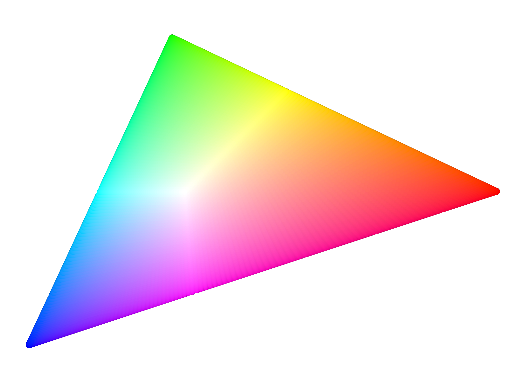

In [9]:
def create_colorspace_grid(resolution=10):
    r, g, b = np.meshgrid(np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution))

    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    return np.vstack([r, g, b]).T

def rgb_to_xyz(rgb):
    rgb = rgb.copy()
    # Transformation matrix from sRGB to XYZ
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    
    # Linearize the gamma-corrected RGB values
    mask = rgb <= 0.04045
    rgb[mask] = rgb[mask] / 12.92
    rgb[~mask] = np.power((rgb[~mask] + 0.055) / 1.055, 2.4)

    # Convert to XYZ
    return np.dot(rgb, M.T)

def xyz_to_xy(xyz):
    sum_xyz = np.sum(xyz, axis=1) + 1e-15  # Adding a small constant to avoid division by zero
    x = xyz[:, 0] / sum_xyz
    y = xyz[:, 1] / sum_xyz
    return np.stack((x, y), axis=1)

def rgb_to_cie_xy(rgb_array):
    xyz_array = rgb_to_xyz(rgb_array)
    return xyz_to_xy(xyz_array)

def plot_colored_coordinates(xy_coords, rgb_values, title, x_markers=None, y_markers=None):
    fig, ax = plt.subplots()
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c=rgb_values, s=10)
    
    if x_markers is not None:
        xy_coords_x = rgb_to_cie_xy(x_markers)
        plt.scatter(xy_coords_x[:, 0], xy_coords_x[:, 1], c='black', s=60, marker='x')

    if y_markers is not None:
        xy_coords_y = rgb_to_cie_xy(y_markers)
        plt.scatter(xy_coords_y[:, 0], xy_coords_y[:, 1], c='black', s=60, marker='o')

    plt.xlim([0.13, 0.65])
    plt.ylim([0, 0.65])

    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.title(title)
    # plt.grid(True)
    plt.axis('off')
    return fig

x_markers = np.array([x])
y_markers = np.array([e_y])
colorspace = create_colorspace_grid(60)
cie_xy_coords = rgb_to_cie_xy(colorspace)
fig = plot_colored_coordinates(cie_xy_coords, colorspace, 'CIE xy Coordinates Colored by RGB Values'); #, x_markers=x_markers, y_markers=y_markers);
plt.show()
fig.savefig('../images/color_space.png', format='png')

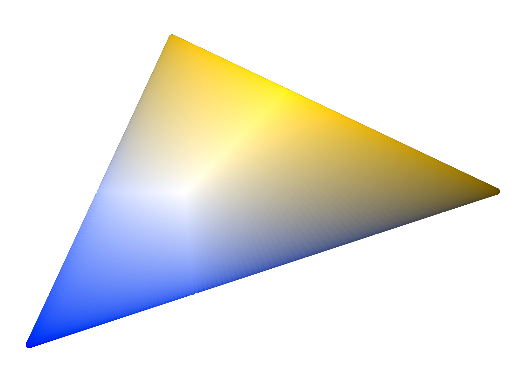

In [10]:
colors_cvd = M.dot(colorspace.T).T.clip(0,1)
fig = plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with Deuteranomaly'); #, x_markers=x_markers, y_markers=y_markers);
plt.show()
fig.savefig('../images/color_space_deuteranomaly.png', format='png')

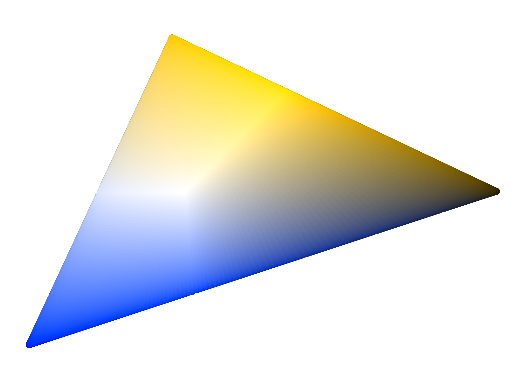

In [11]:
M = colour.blindness.matrix_cvd_Machado2009('Protanomaly', 1)
colors_cvd = M.dot(colorspace.T).T.clip(0,1)
fig = plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with Deuteranomaly'); #, x_markers=x_markers, y_markers=y_markers);
plt.show()
fig.savefig('../images/color_space_protanomaly.png', format='png')

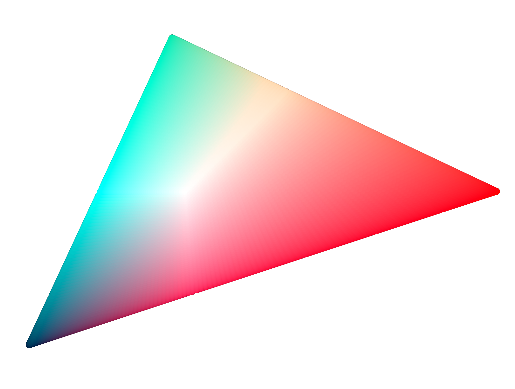

In [12]:
M = colour.blindness.matrix_cvd_Machado2009('Tritanomaly', 1)
colors_cvd = M.dot(colorspace.T).T.clip(0,1)
fig = plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with Deuteranomaly'); #, x_markers=x_markers, y_markers=y_markers);
plt.show()
fig.savefig('../images/color_space_tritanomaly.png', format='png')